In [1]:
import pybaseball
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils
import plotly.express as px
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['text.usetex'] = True

### Plotting Hit Position

Plotting the hit position of all batted outs, singles, doubles, triples and home runs between 7-4-2022 and 7-6-2022

In [2]:
sample = pybaseball.statcast('2022-07-04', '2022-07-06')

This is a large query, it may take a moment to complete


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


In [3]:
sample = sample[sample['hc_x'].notnull() 
                & sample['hc_y'].notnull() 
                & sample['events'].notnull() 
                & sample['launch_speed'].notnull()
                & sample['launch_angle'].notnull()]
sample['normalized_hc_x'] = sample.apply(lambda row: row['hc_x'] - 128, axis=1)
sample['normalized_hc_y'] = sample.apply(lambda row: 200 - row['hc_y'], axis=1)
sample['horizontal_angle'] = sample.apply(lambda row: utils.horizontal_angle(row['hc_x'], row['hc_y']), axis=1)
sample['result'] = sample.apply(lambda row: utils.EVENT_VALUE.get(row['events'], 0), axis=1)
out = sample[~sample['events'].isin(['single', 'double', 'triple', 'home_run'])]
single = sample[sample['events'] == 'single']
double = sample[sample['events'] == 'double']
triple = sample[sample['events'] == 'triple']
home_run = sample[sample['events'] == 'home_run']

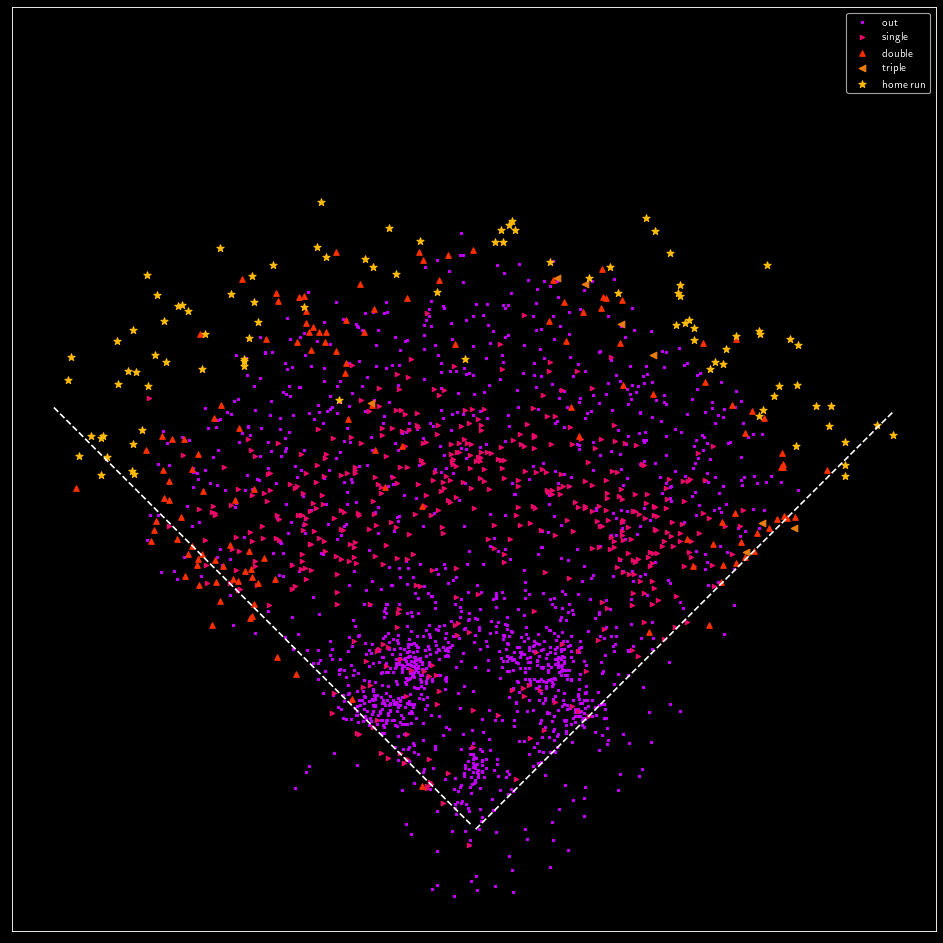

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(out['normalized_hc_x'], out['normalized_hc_y'], s=5, c=utils.EVENT_COLOR['out'], marker=utils.EVENT_MARKER['out'], label='out')
plt.scatter(single['normalized_hc_x'], single['normalized_hc_y'], s=15, c=utils.EVENT_COLOR['single'], marker=utils.EVENT_MARKER['single'], label='single')
plt.scatter(double['normalized_hc_x'], double['normalized_hc_y'], s=25, c=utils.EVENT_COLOR['double'], marker=utils.EVENT_MARKER['double'], label='double')
plt.scatter(triple['normalized_hc_x'], triple['normalized_hc_y'], s=35, c=utils.EVENT_COLOR['triple'], marker=utils.EVENT_MARKER['triple'], label='triple')
plt.scatter(home_run['normalized_hc_x'], home_run['normalized_hc_y'], s=45, c=utils.EVENT_COLOR['home_run'], marker=utils.EVENT_MARKER['home_run'], label='home run')
plt.legend()
plt.plot(np.arange(-120, 0), np.arange(120, 0, step=-1), c='white', linestyle='dashed')
plt.plot(np.arange(120), c='white', linestyle='dashed')
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.show()

Recreating the same graph using plotly for more user interactivity.

In [5]:
# draw left and right field lines
right_foul_line = px.line(
    x=[0, 130],
    y=[0, 130],
    color_discrete_sequence=['white'],
)
left_foul_line = px.line(
    x=[-130, 0],
    y=[130, 0],
    color_discrete_sequence=['white'],
)
foul_lines = go.Figure(data=right_foul_line.data + left_foul_line.data)

# add marker size and batted ball result fields to dataframe
marker_sizes = {
    'out': 0.2,
    'single': 1.0,
    'double': 3.0,
    'triple': 5.0,
    'home run': 6.0,
}
color_map = dict(utils.EVENT_COLOR)
home_run_color = color_map.pop('home_run')
color_map['home run'] = home_run_color
sample['result_name'] = sample.apply(lambda row: utils.RESULT_NAME[row['result']], axis=1)
sample['size'] = sample.apply(lambda row: marker_sizes[row['result_name']], axis=1)

batted_balls = px.scatter(
    sample, 
    x='normalized_hc_x', 
    y='normalized_hc_y', 
    color='result_name',
    size='size',
    color_discrete_map=color_map,
    category_orders={'result_name': ['home run', 'triple', 'double', 'single', 'out']},
    hover_data={
        'events': True,
        'launch_speed': True,
        'launch_angle': True,
        'size': False,
        'normalized_hc_x': False,
        'normalized_hc_y': False,
        'result_name': False,
    }
)
fig = go.Figure(data=foul_lines.data + batted_balls.data)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(showlegend=True, legend_title=None)
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.2,
    xanchor="left",
    x=0.01
))
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
)
fig.update_layout(
    template='plotly_dark',
    width=900,
    height=900,
)

fig.show()

### Launch Speed

Distribution of launch speed and outcome of batted balls between 7-4-2022 and 7-6-2022. Expected outcome is computed by the average outcome from all batted balls within a particular window of launch speeds.

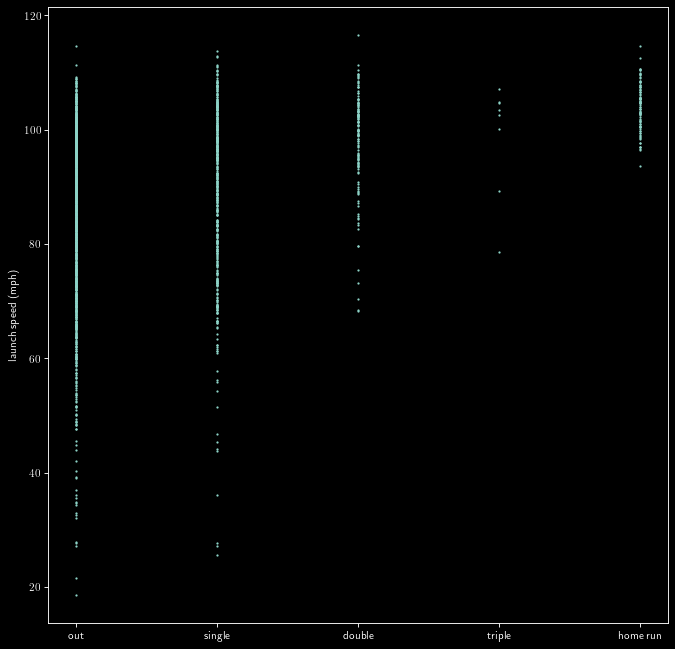

In [6]:
sample = sample.sort_values(by=['launch_speed'], ascending=True, ignore_index=True)
speeds = sample['launch_speed'].to_numpy()
results = sample['result'].to_numpy()

plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('launch speed (mph)')
plt.scatter(results, speeds, s=1)
plt.xticks([0, 1, 2, 3, 4], ['out', 'single', 'double', 'triple', 'home run'])
plt.show()

/var/folders/x7/jz6hp53x0bx8q7dgr58tb54h0000gn/T/ipykernel_76273/1008438857.py:12: RuntimeWarning:

invalid value encountered in true_divide



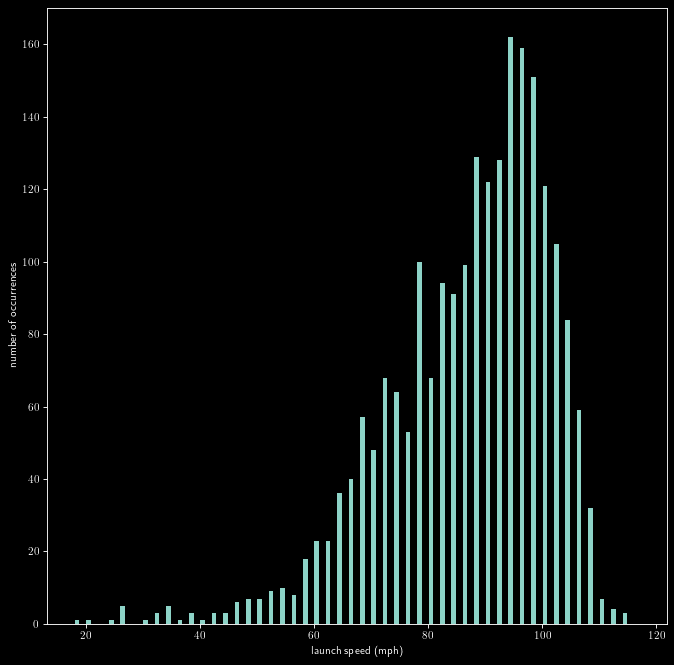

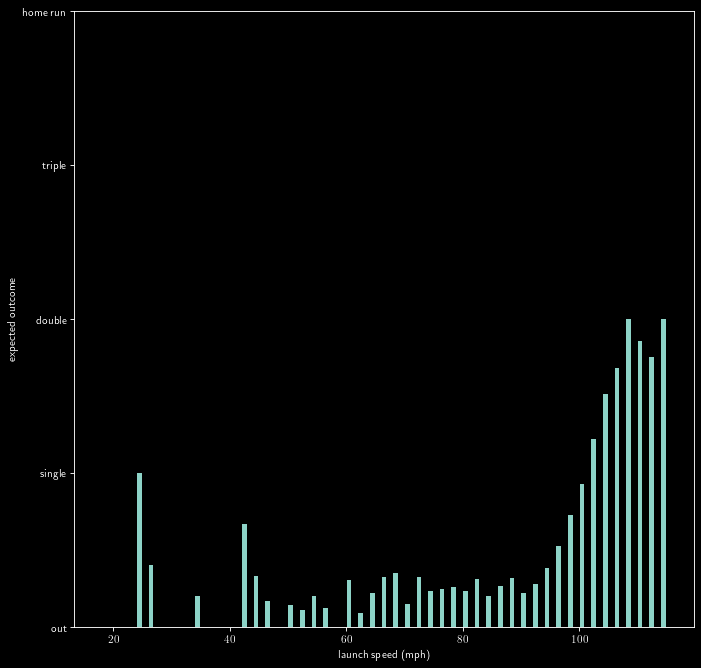

In [7]:
min_speed = np.amin(speeds)
max_speed = np.amax(speeds)
num_buckets = 50
bucket_freqs = np.zeros(num_buckets)
bucket_sums = np.zeros(num_buckets)
bucket_width = (max_speed + 0.001 - min_speed) / (num_buckets - 1)
buckets = np.arange(min_speed, max_speed + bucket_width, bucket_width)
for i in range(len(speeds)):
    bucket_idx = int((speeds[i] - min_speed) / bucket_width)
    bucket_freqs[bucket_idx] += 1
    bucket_sums[bucket_idx] += results[i]
bucket_avg = bucket_sums / bucket_freqs

plt.figure(figsize=(10, 10), dpi=80)
plt.ylabel('number of occurrences')
plt.xlabel('launch speed (mph)')
plt.bar(buckets, bucket_freqs)
plt.show()

plt.figure(figsize=(10, 10), dpi=80)
plt.bar(buckets, bucket_avg)
plt.xlabel('launch speed (mph)')
plt.ylabel('expected outcome')
plt.yticks([0, 1, 2, 3, 4], ['out', 'single', 'double', 'triple', 'home run'])
plt.show()

### Vertical Launch Angle

Distribution of vertical launch angle and outcome of batted balls between 7-4-2022 and 7-6-2022. Expected outcome is computed by the average outcome from all batted balls within a particular window of vertical launch angles.

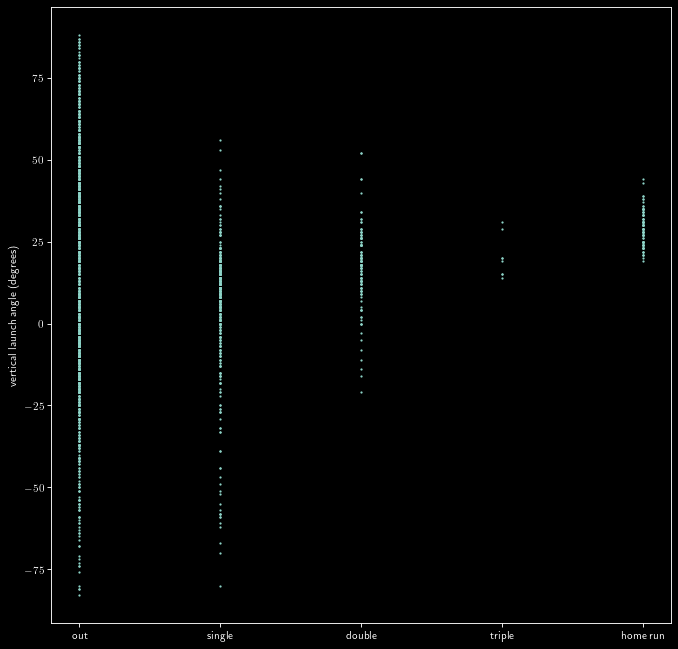

In [8]:
sample = sample.sort_values(by=['launch_angle'], ascending=True, ignore_index=True)
angles = sample['launch_angle'].to_numpy()
results = sample['result'].to_numpy()

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(results, angles, s=1)
plt.xticks([0, 1, 2, 3, 4], ['out', 'single', 'double', 'triple', 'home run'])
plt.ylabel('vertical launch angle (degrees)')
plt.show()

/var/folders/x7/jz6hp53x0bx8q7dgr58tb54h0000gn/T/ipykernel_76273/3529208187.py:12: RuntimeWarning:

invalid value encountered in true_divide



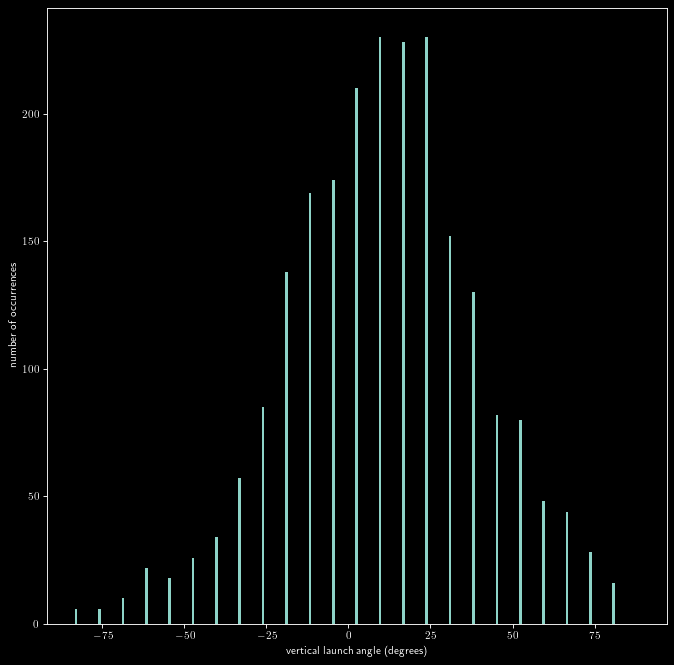

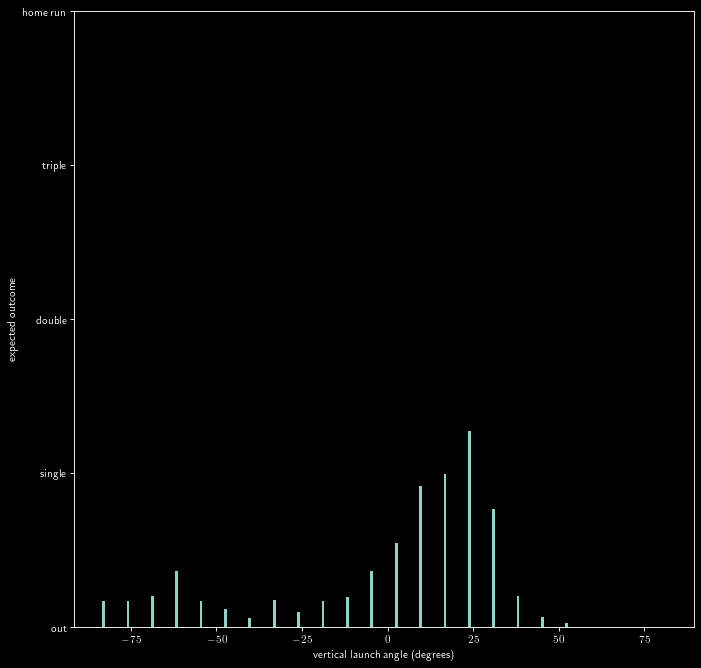

In [9]:
min_angle = np.amin(angles)
max_angle = np.amax(angles)
num_buckets = 25
bucket_freqs = np.zeros(num_buckets)
bucket_sums = np.zeros(num_buckets)
bucket_width = (max_angle + 0.001 - min_angle) / (num_buckets - 1)
buckets = np.arange(min_angle, max_angle + bucket_width, bucket_width)
for i in range(len(angles)):
    bucket_idx = int((angles[i] - min_angle) / bucket_width)
    bucket_freqs[bucket_idx] += 1
    bucket_sums[bucket_idx] += results[i]
bucket_avg = bucket_sums / bucket_freqs

plt.figure(figsize=(10, 10), dpi=80)
plt.bar(buckets, bucket_freqs)
plt.xlabel('vertical launch angle (degrees)')
plt.ylabel('number of occurrences')
plt.show()

plt.figure(figsize=(10, 10), dpi=80)
plt.bar(buckets, bucket_avg)
plt.yticks([0, 1, 2, 3, 4], ['out', 'single', 'double', 'triple', 'home run'])
plt.xlabel('vertical launch angle (degrees)')
plt.ylabel('expected outcome')
plt.show()

### Horizontal Launch Angle

Distribution of horizontal launch angle and outcome of batted balls between 7-4-2022 and 7-6-2022. Expected outcome is computed by the average outcome from all batted balls within a particular window of horizontal launch angles.

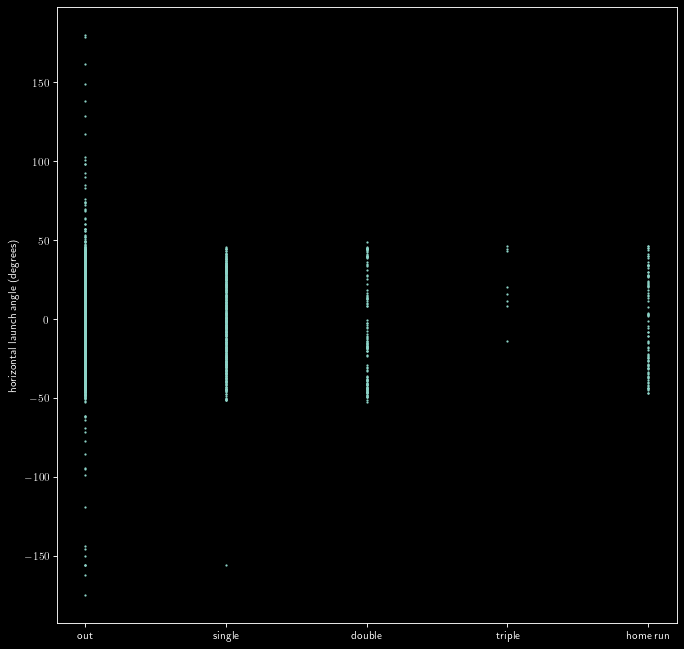

In [10]:
sample = sample.sort_values(by=['horizontal_angle'], ascending=True, ignore_index=True)
angles = sample['horizontal_angle'].to_numpy()
results = sample['result'].to_numpy()

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(results, angles, s=1)
plt.ylabel('horizontal launch angle (degrees)')
plt.xticks([0, 1, 2, 3, 4], ['out', 'single', 'double', 'triple', 'home run'])
plt.show()

/var/folders/x7/jz6hp53x0bx8q7dgr58tb54h0000gn/T/ipykernel_76273/37908292.py:12: RuntimeWarning:

invalid value encountered in true_divide



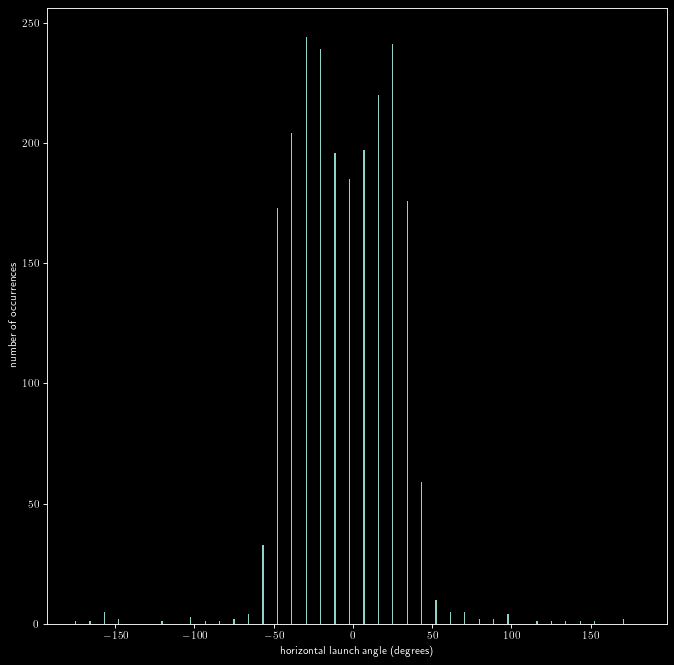

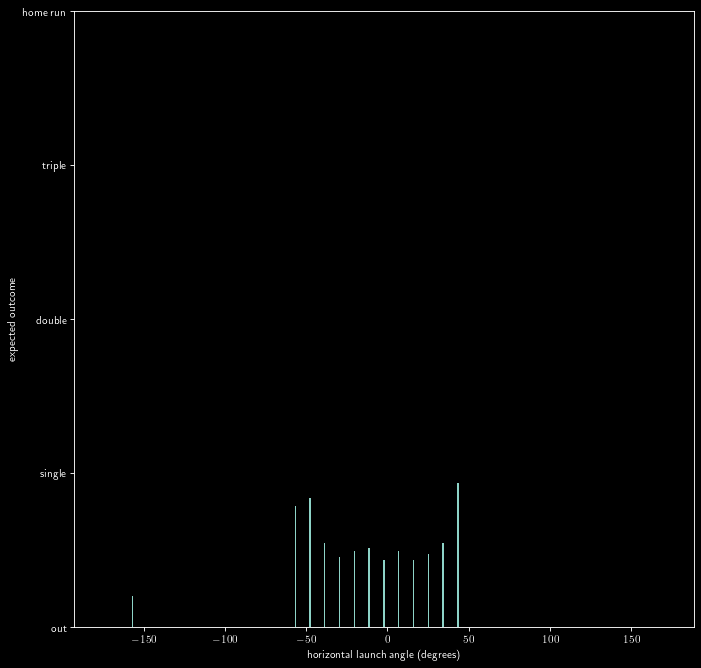

In [11]:
min_angle = np.amin(angles)
max_angle = np.amax(angles)
num_buckets = 40
bucket_freqs = np.zeros(num_buckets)
bucket_sums = np.zeros(num_buckets)
bucket_width = (max_angle + 0.001 - min_angle) / (num_buckets - 1)
buckets = np.arange(min_angle, max_angle + bucket_width, bucket_width)
for i in range(len(angles)):
    bucket_idx = int((angles[i] - min_angle) / bucket_width)
    bucket_freqs[bucket_idx] += 1
    bucket_sums[bucket_idx] += results[i]
bucket_avg = bucket_sums / bucket_freqs

plt.figure(figsize=(10, 10), dpi=80)
plt.bar(buckets, bucket_freqs)
plt.xlabel('horizontal launch angle (degrees)')
plt.ylabel('number of occurrences')
plt.show()

plt.figure(figsize=(10, 10), dpi=80)
plt.bar(buckets, bucket_avg)
plt.xlabel('horizontal launch angle (degrees)')
plt.ylabel('expected outcome')
plt.yticks([0, 1, 2, 3, 4], ['out', 'single', 'double', 'triple', 'home run'])
plt.show()

### Vertical Launch Angle and Launch Speed

Distribution of launch speed and vertical launch angle of batted balls between 7-4-2022 and 7-6-2022.

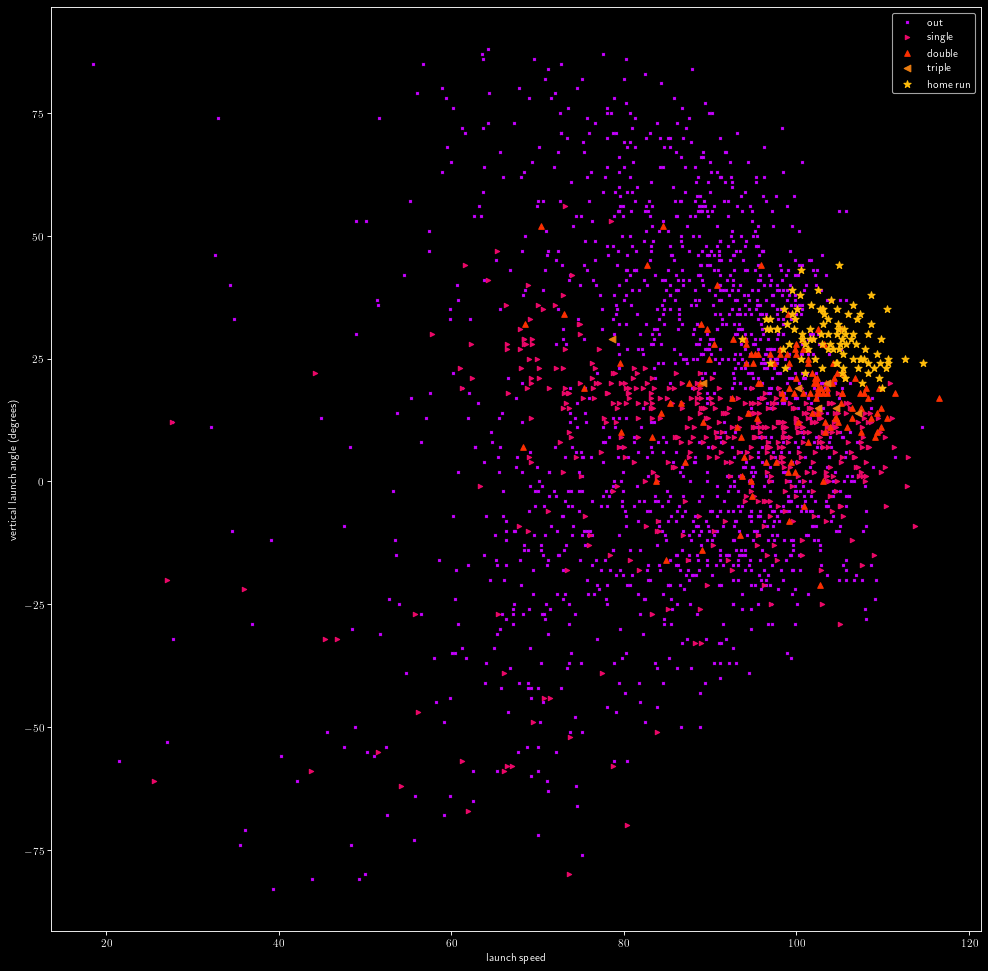

In [12]:
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(out['launch_speed'], out['launch_angle'], s=5, c=utils.EVENT_COLOR['out'], marker=utils.EVENT_MARKER['out'], label='out')
plt.scatter(single['launch_speed'], single['launch_angle'], s=15, c=utils.EVENT_COLOR['single'], marker=utils.EVENT_MARKER['single'], label='single')
plt.scatter(double['launch_speed'], double['launch_angle'], s=25, c=utils.EVENT_COLOR['double'], marker=utils.EVENT_MARKER['double'], label='double')
plt.scatter(triple['launch_speed'], triple['launch_angle'], s=35, c=utils.EVENT_COLOR['triple'], marker=utils.EVENT_MARKER['triple'], label='triple')
plt.scatter(home_run['launch_speed'], home_run['launch_angle'], s=45, c=utils.EVENT_COLOR['home_run'], marker=utils.EVENT_MARKER['home_run'], label='home run')
plt.xlabel('launch speed')
plt.ylabel('vertical launch angle (degrees)')
plt.legend()
plt.show()

### Horizontal Launch Angle and Launch Speed

Distribution of launch speed and horizontal launch angle of batted balls between 7-4-2022 and 7-6-2022.

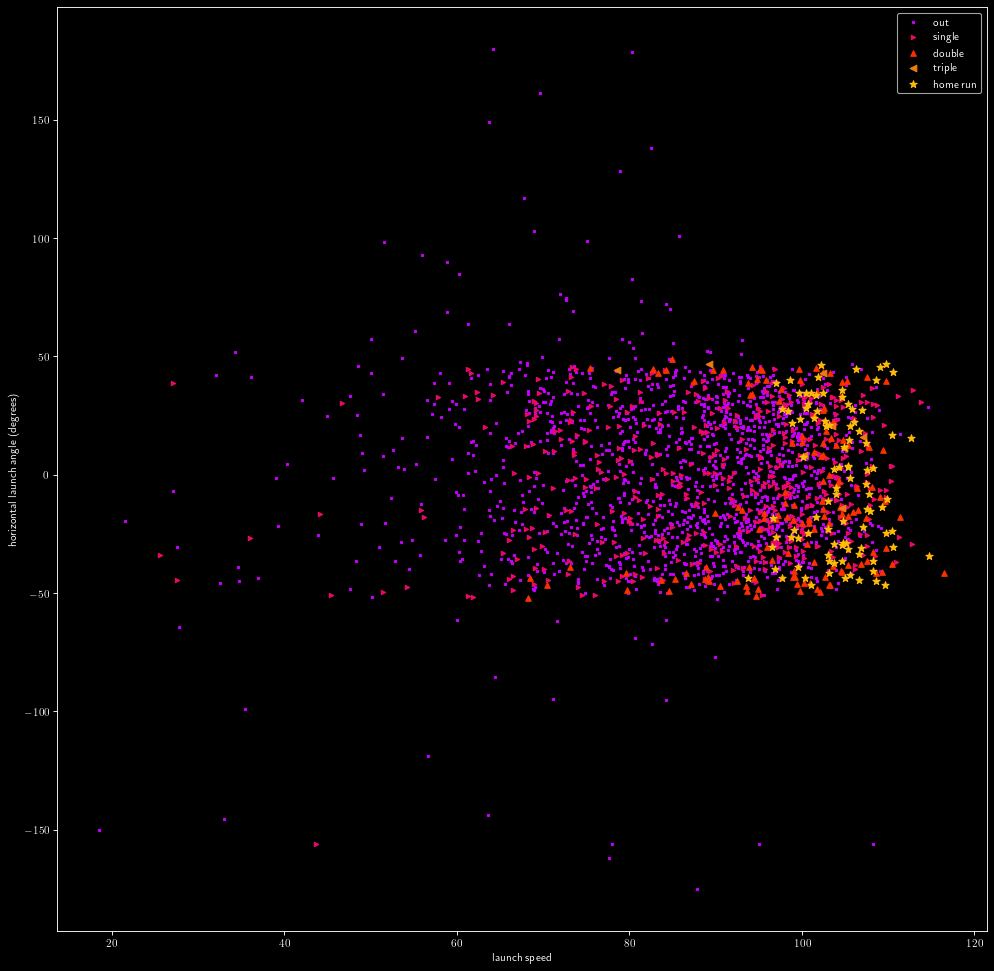

In [13]:
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(out['launch_speed'], out['horizontal_angle'], s=5, c=utils.EVENT_COLOR['out'], marker=utils.EVENT_MARKER['out'], label='out')
plt.scatter(single['launch_speed'], single['horizontal_angle'], s=15, c=utils.EVENT_COLOR['single'], marker=utils.EVENT_MARKER['single'], label='single')
plt.scatter(double['launch_speed'], double['horizontal_angle'], s=25, c=utils.EVENT_COLOR['double'], marker=utils.EVENT_MARKER['double'], label='double')
plt.scatter(triple['launch_speed'], triple['horizontal_angle'], s=35, c=utils.EVENT_COLOR['triple'], marker=utils.EVENT_MARKER['triple'], label='triple')
plt.scatter(home_run['launch_speed'], home_run['horizontal_angle'], s=45, c=utils.EVENT_COLOR['home_run'], marker=utils.EVENT_MARKER['home_run'], label='home run')
plt.xlabel('launch speed')
plt.ylabel('horizontal launch angle (degrees)')
plt.legend()
plt.show()

### Horizontal Launch Angle and Vertical Launch Angle

Distribution of horizontal and vertical launch angles of batted balls between 7-4-2022 and 7-6-2022.

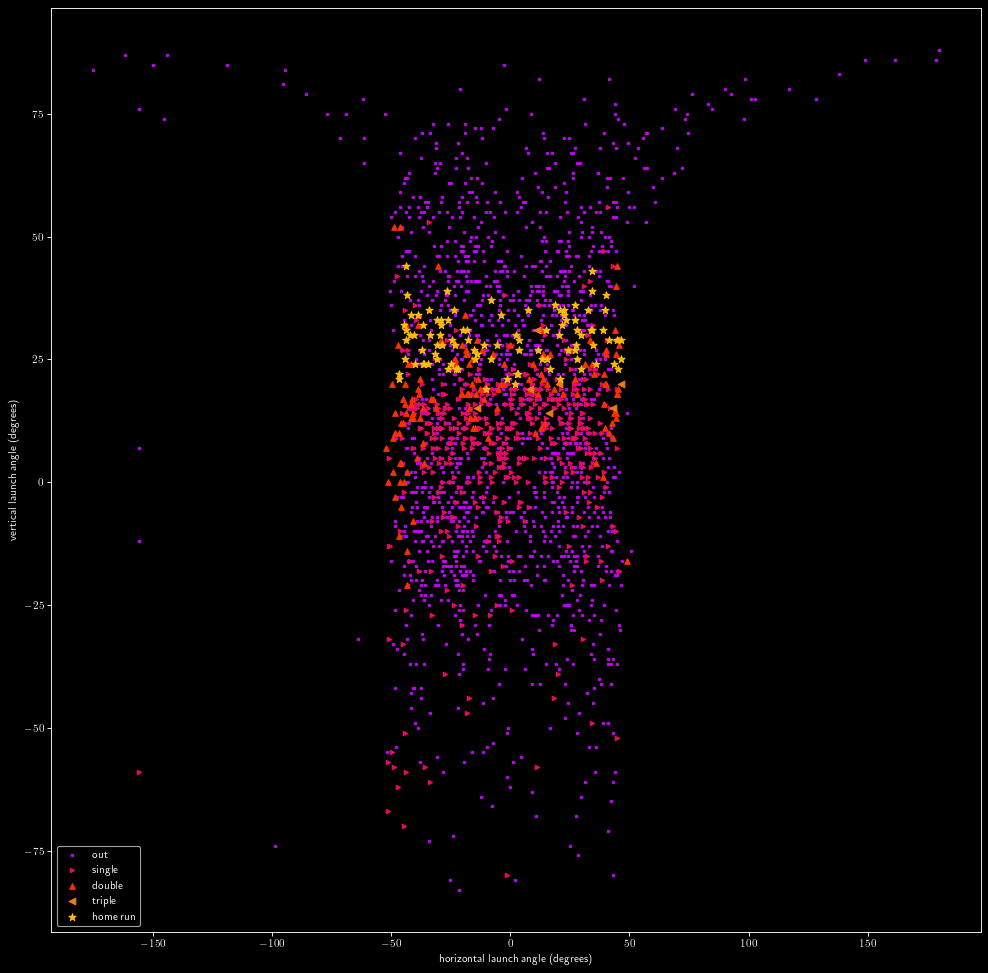

In [14]:
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(out['horizontal_angle'], out['launch_angle'], s=5, c=utils.EVENT_COLOR['out'], marker=utils.EVENT_MARKER['out'], label='out')
plt.scatter(single['horizontal_angle'], single['launch_angle'], s=15, c=utils.EVENT_COLOR['single'], marker=utils.EVENT_MARKER['single'], label='single')
plt.scatter(double['horizontal_angle'], double['launch_angle'], s=25, c=utils.EVENT_COLOR['double'], marker=utils.EVENT_MARKER['double'], label='double')
plt.scatter(triple['horizontal_angle'], triple['launch_angle'], s=35, c=utils.EVENT_COLOR['triple'], marker=utils.EVENT_MARKER['triple'], label='triple')
plt.scatter(home_run['horizontal_angle'], home_run['launch_angle'], s=45, c=utils.EVENT_COLOR['home_run'], marker=utils.EVENT_MARKER['home_run'], label='home run')
plt.ylabel('vertical launch angle (degrees)')
plt.xlabel('horizontal launch angle (degrees)')
plt.legend()
plt.show()